# Grop Recommender System

In [137]:
import pandas as pd


## Import the dataset using in the slim version

In [138]:
ratings_df = pd.read_csv("XWines_Slim_150K_ratings.csv") 


In [139]:
ratings_df = ratings_df.drop(columns=['Vintage', 'Date'])


In [140]:
wine_df = pd.read_csv('XWines_Slim_1K_wines.csv', index_col="WineID")


#### 2. Preprocessing


We have decided to remove all the wine that lees than 10 ratings and all the users tried less than 10 wines.

In [141]:
# Check number of ratings per WineID
rating_per_WineID_df = ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)


# Check number of ratings per user
rating_per_user_df = ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)


In [142]:
min_ratings_per_WineID = 10
min_ratings_per_user = 10

#this is wrong
#min_ratings_per_WineID = 10
#min_ratings_per_user = 10

In [143]:
# select WineIDs with the desidered number of ratings
selected_WineIDs = list(rating_per_WineID_df.loc[rating_per_WineID_df['Rating'] >= min_ratings_per_WineID].reset_index()['WineID'])

selected_ratings_df = ratings_df.loc[ratings_df['WineID'].isin(selected_WineIDs)]


# Check number of ratings per WineID
rating_per_WineID_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)


# Check number of ratings per user
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)


In [144]:
# select users with the desidered number of ratings
selected_users = list(rating_per_user_df.loc[rating_per_user_df['Rating'] >= min_ratings_per_user].reset_index()['UserID'])

selected_ratings_df = selected_ratings_df.loc[ratings_df['UserID'].isin(selected_users)]


# Check number of ratings per WineID
rating_per_WineID_df = selected_ratings_df.groupby(['WineID']).count().sort_values(by="Rating", ascending=False)


# Check number of ratings per user
rating_per_user_df = selected_ratings_df.groupby(['UserID']).count().sort_values(by="Rating", ascending=False)


## 3. Group Generation
#### 3.1 Similarity metric

We calculated the Pearson Similarity.

In [145]:
# computing pearson similarity between each pair of users

import numpy as np

ratings_df = selected_ratings_df

user_matrix = ratings_df.pivot_table(columns='WineID', index='UserID', values='Rating')

user_id_set = set(ratings_df['UserID'])
user_id_indexes = user_matrix.index.values

user_matrix = user_matrix.fillna(0)
numpy_array = user_matrix.to_numpy()
sim_matrix = np.corrcoef(numpy_array)


Text(0.5, 0, "Pearson's Correlation Coeficient")

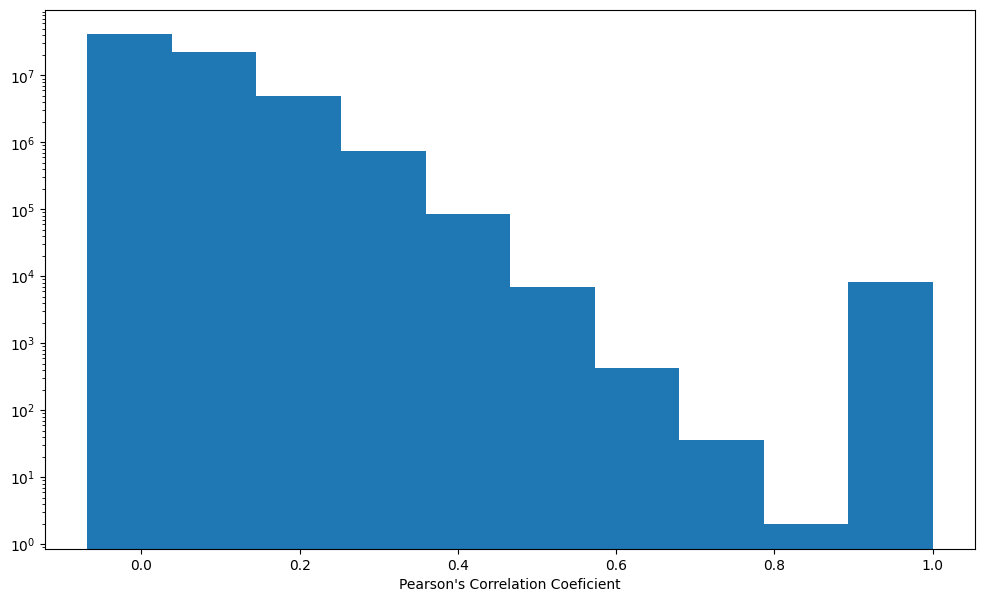

In [146]:
# visualizing similarity distributions

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(sim_matrix.flatten())
plt.yscale("log")
plt.xlabel("Pearson's Correlation Coeficient")

#### 3.2 Group Generation

We separatly generated 20 groups for sizes 2,3,4,5,6,7,8 based on RANDOM and SIMILAR

In [147]:
from importlib import reload

import aggregators as groups_gen_utils
reload(groups_gen_utils)
import groups_generators as groups_gen_utils

#group_sizes_to_create = [2,4,8] 
group_sizes_to_create = [2, 3, 4, 5, 6, 7, 8]
group_similarity_to_create = [groups_gen_utils.GroupsGenerator.RANDOM,groups_gen_utils.GroupsGenerator.SIMILAR]
group_number = 20

group_list = list()
for group_to_create in group_similarity_to_create:
    grpGenerator = groups_gen_utils.GroupsGenerator.getGroupsGenerator(group_to_create)
    current_group_list = grpGenerator.generateGroups(user_id_indexes, user_id_set, sim_matrix, group_sizes_to_create, group_number)
    group_list = group_list + current_group_list

groups_df = pd.DataFrame.from_records(group_list)
group_dict = dict()
for group_id, group in zip(range(len(group_list)), group_list):
    group_dict[group_id] = group
    



20
40
60
80
100
120
140
20
40
60
80
100
120
140


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


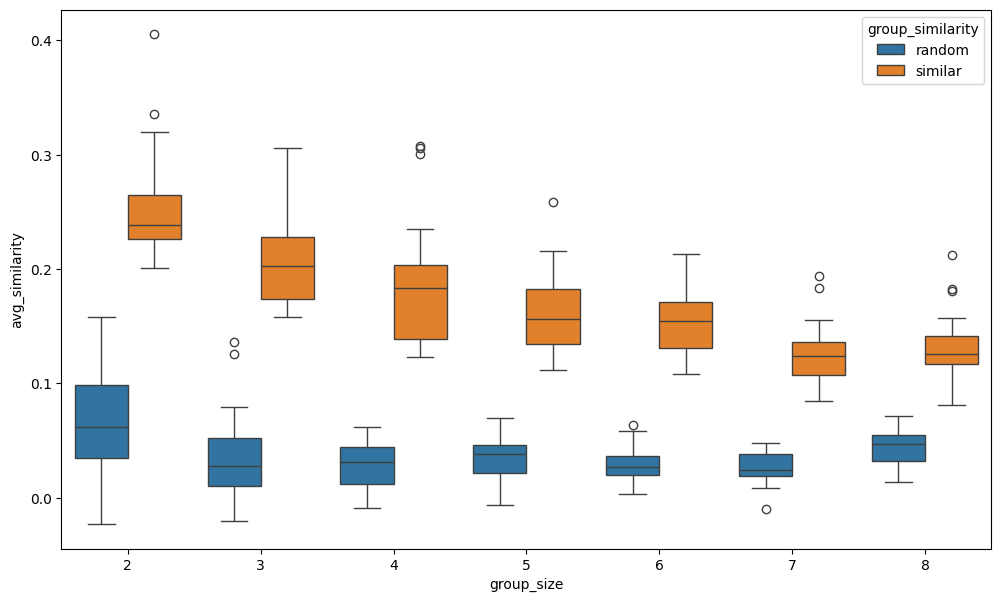

In [148]:
# Visualizing similarities for each type of group we created

import seaborn as sns


plt.rcParams["figure.figsize"] = (12,7)
sns.boxplot(x = groups_df['group_size'],
            y = groups_df['avg_similarity'],
            hue = groups_df['group_similarity'])
import matplotlib.pyplot as plt

#### 4. Train/Test Split

In [149]:
ratings_df =ratings_df.rename(columns={
    'RatingID': 'ratingId', 
    'UserID': 'user',
    'WineID': 'item',
    'Rating': 'rating'
    
})

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

display(ratings_df.shape)
WineIDs = set(ratings_df["item"].tolist())
users = set(ratings_df["user"].tolist())



train_df, test_df = train_test_split(ratings_df, test_size=0.2, stratify=ratings_df[["user"]])



(132694, 4)

#### 5. Individual RS training and generating predicted ratings.


In [151]:
train_df = train_df.rename(columns={
    'RatingID': 'ratingId',  
    'UserID': 'user',
    'WineID': 'item',
    
    'Rating': 'rating'
    
})


We used Item-Item model created for the personal recommender.

In [152]:
import Recommender as RC

recommender = RC.Recommender()
recommender.load_model("item-item")



INFO:root:Loading model: item-item


In [153]:
# Generate predicted ratings

# test_df['predicted_rating'] = recsys.predict(test_df)
test_WineID = set(test_df["item"].tolist())
test_user = set(test_df["user"].tolist())
test_rating=set(test_df["rating"].tolist())

display(len(test_WineID))
display(len(test_user))
display(len(test_rating))
display(test_rating)

831

8333

9

{1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0}

In [154]:
extended_test_df = pd.DataFrame({'item': list(test_WineID)}).merge(pd.DataFrame({'user': list(test_user)}), how='cross')
display(extended_test_df)

,item,user
0,112641,1245188
1,112641,1245200
2,112641,1212437
3,112641,1212442
4,112641,1212444
...,...,...
6924718,163839,1179634
6924719,163839,1179637
6924720,163839,1703926
6924721,163839,1048570


In [155]:
extended_test_df['rating'] = recommender.predict(extended_test_df)

display(extended_test_df)



,item,user,rating
0,112641,1245188,3.683231
1,112641,1245200,3.151618
2,112641,1212437,3.714943
3,112641,1212442,3.137912
4,112641,1212444,3.407169
...,...,...,...
6924718,163839,1179634,3.253251
6924719,163839,1179637,3.619521
6924720,163839,1703926,3.122807
6924721,163839,1048570,3.413418


#### 6. Aggregation strategies: generating group recommendations



In [156]:
import aggregators as aggr_utils
reload(aggr_utils)
import aggregators as aggr_utils

aggregation_strategies = ["BASE"]
recommendations_number = 10

def generate_group_recommendations_forall_groups(test_df, group_dict, recommendations_number):
    group_recommendations = dict()
    for group_id in group_dict:
        
#         print(datetime.now(), group_id)
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
            
        group_ratings = test_df.loc[test_df['user'].isin(group_members)]
        
        group_rec = dict()
        for aggregation_strategy in aggregation_strategies:
            agg = aggr_utils.AggregationStrategy.getAggregator(aggregation_strategy)
            group_rec = {**group_rec, **agg.generate_group_recommendations_for_group(group_ratings, recommendations_number)}
        
        
        group_recommendations[group_id] = group_rec
        
    return group_recommendations

In [157]:
group_recommendations = generate_group_recommendations_forall_groups(extended_test_df, group_dict, recommendations_number)

display(group_recommendations)

{0: {'ADD': [144337,
   112084,
   182711,
   180330,
   181280,
   174184,
   179061,
   111415,
   111395,
   162497],
  'MUL': [144337,
   112084,
   182711,
   180330,
   181280,
   174184,
   179061,
   111415,
   111395,
   162497],
  'LMS': [182711,
   144337,
   181280,
   112084,
   180330,
   112664,
   184540,
   141799,
   182081,
   111415],
  'MPL': [112084,
   174184,
   179061,
   180330,
   196663,
   112950,
   162497,
   144337,
   137224,
   179855]},
 1: {'ADD': [183379,
   182711,
   112084,
   180330,
   111415,
   181280,
   194674,
   179043,
   179855,
   111395],
  'MUL': [183379,
   182711,
   112084,
   180330,
   111415,
   181280,
   194674,
   179043,
   179855,
   111395],
  'LMS': [183379,
   182081,
   112084,
   180330,
   182711,
   181280,
   111415,
   196091,
   179043,
   194674],
  'MPL': [182711,
   112084,
   183379,
   180330,
   112664,
   111415,
   179855,
   140819,
   111395,
   179805]},
 2: {'ADD': [182169,
   112084,
   174184,
   14

In [158]:
# Visualize the group recommendation
group_recommender_full_dataframe=group_recommendations
wine_df.reset_index(inplace=True)

wine_df= pd.DataFrame(wine_df)
recommendations_df = pd.DataFrame([
    {'strategy': strategy, 'wine_id': wine_id}
    for strategy, wine_ids in group_recommendations.items()
    for wine_id in wine_ids
])
recommendations_list = []
for group_id, strategies in group_recommendations.items():
    for strategy, wine_ids in strategies.items():
        for wine_id in wine_ids:
            recommendations_list.append({'group_id': group_id, 'strategy': strategy, 'wine_id': wine_id})

recommendations_df = pd.DataFrame(recommendations_list)

recommendations_df['wine_id'] = recommendations_df['wine_id'].astype(str)
wine_df['WineID'] = wine_df['WineID'].astype(str)  
merged_df = recommendations_df.merge(wine_df, left_on='wine_id', right_on='WineID', how='left')


for group_id in merged_df['group_id'].unique():
    group_df = merged_df[merged_df['group_id'] == group_id][['group_id', 'strategy', 'wine_id', 'WineName']]
    print(f"DataFrame for group '{group_id}':")
    print(group_df)
    print("\n")



DataFrame for group '0':
    group_id strategy wine_id                             WineName
0          0      ADD  144337      Tre Soli Tre Grappa Invecchiata
1          0      ADD  112084            Oenothèque Brut Champagne
2          0      ADD  182711                               Solari
3          0      ADD  180330                        IX Estate Red
4          0      ADD  181280                            Red Blend
5          0      ADD  174184                               Grange
6          0      ADD  179061                             Insignia
7          0      ADD  111415  Pauillac (Premier Grand Cru Classé)
8          0      ADD  111395  Pauillac (Premier Grand Cru Classé)
9          0      ADD  162497                   Cabernet Sauvignon
10         0      MUL  144337      Tre Soli Tre Grappa Invecchiata
11         0      MUL  112084            Oenothèque Brut Champagne
12         0      MUL  182711                               Solari
13         0      MUL  180330        

#### 7. Evaluation

We used the Coupled and Coupled Evaluation.

#### 7.1 NDCG metric

- We see an implementation of the NDCG metric.


In [159]:
def evaluateUserNDCG(user_ground_truth, group_recommendation):
    dcg = 0

    for k, item in enumerate(group_recommendation):
        dcg = dcg + ((user_ground_truth.loc[item, "final_rating"] if item in user_ground_truth.index else 0) / np.log2(k + 2)) # +2? CHeck with the course slides

    idcg = 0
    user_ground_truth.sort_values("final_rating", inplace=True, ascending=False)
    for k in range(min(len(user_ground_truth), len(group_recommendation))):
        idcg = idcg + (user_ground_truth.iloc[k]["final_rating"] / np.log2(k + 2)) # +2? CHeck with the course slides
    if idcg > 0:
        ndcg = dcg / idcg
    else:
        ndcg = 0

    return ndcg


#### 7.2 Aggregating metric for group members

- We report results aggregating using: mean, min, minmax.

In [160]:
def evaluateGroupRecommendation(group_ground_truth, group_recommendation, group_members):
    ndcg_list = list()
    dcg_list = list()
    binarize_feedback=False
    binarize_feedback_positive_threshold=10
    for user in group_members:
        
        user_ground_truth = group_ground_truth.loc[group_ground_truth['user'] == user]
        user_ground_truth.set_index("item", inplace=True)

        # feedback binarization
        if binarize_feedback == True:
            user_ground_truth["final_rating"] = 0
            user_ground_truth.loc[user_ground_truth.rating >= binarize_feedback_positive_threshold,"final_rating"] = 1         
        # no modifications to feedback
        else:
            user_ground_truth["final_rating"] = user_ground_truth["rating"]
        
        ndcg_user = evaluateUserNDCG(user_ground_truth, group_recommendation)
        ndcg_list.append(ndcg_user)

        # failsafe for all negative results
        if np.amax(ndcg_list) > 0:
            ndcg_min_max = np.amin(ndcg_list) / np.amax(ndcg_list)
        else:
            ndcg_min_max = 0.0
            dcg_min_max = 0.0
    return [
        {
            "metric": "NDCG",
            "aggr_metric": "mean",
            "value": np.mean(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "min",
            "value": np.amin(ndcg_list)
        },
        {
            "metric": "NDCG",
            "aggr_metric": "minmax",
            "value": ndcg_min_max
        }
    ]



#### 7.3 Evaluating recommendations for all the groups

In [161]:
def evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict):
                                                 
    group_evaluations = list()
    for group_id in group_dict:
        
        
        # extract group info
        group = group_dict[group_id]
        group_size = group['group_size']
        group_similarity = group['group_similarity']
        group_members = group['group_members']
        group_rec = group_recommendations[group_id]
            
        # filter ratings in ground_truth for the group members
        group_ground_truth = ground_truth.loc[ground_truth['user'].isin(group_members)]
        

        for aggregation_strategy in group_rec:
            agg_group_rec = group_rec[aggregation_strategy]
            agg_group_rec_eval = evaluateGroupRecommendation(group_ground_truth, agg_group_rec, group_members)
    
            # Adding aggregation strategy info
            for row in agg_group_rec_eval:
                row['aggregation_strategy'] = aggregation_strategy
                row['group_id'] = group_id

            group_evaluations = group_evaluations + agg_group_rec_eval
        
    return group_evaluations    

In [162]:

test_df=test_df.drop(columns=['rating'])
print(test_df.columns)

Index(['ratingId', 'user', 'item'], dtype='object')


In [163]:
# Reorder columns by specifying the desired order
train_df = train_df[['item', 'user', 'rating']]

# Verify the new column order
print(train_df.columns)


Index(['item', 'user', 'rating'], dtype='object')


#### 7.4 Decoupled Evaluation

- In this case the ground truth are the predicted ratings

In [164]:
import warnings
warnings.filterwarnings('ignore')

ground_truth = extended_test_df
decoupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(decoupled_results)


[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9899951798888869,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9886310779397111,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9972480169920908,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9899951798888869,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9886310779397111,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9972480169920908,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': '

In [165]:
ground_truth['rating'] = recommender.predict(ground_truth)
display(ground_truth.head(3))
coupled_results = evaluate_group_recommendations_forall_groups(ground_truth, group_recommendations, group_dict)
display(coupled_results)


,item,user,rating
0,112641,1245188,3.683231
1,112641,1245200,3.151618
2,112641,1212437,3.714943


[{'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9899951798888869,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9886310779397111,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9972480169920908,
  'aggregation_strategy': 'ADD',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': 0.9899951798888869,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': 0.9886310779397111,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'minmax',
  'value': 0.9972480169920908,
  'aggregation_strategy': 'MUL',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'mean',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': 'NDCG',
  'aggr_metric': 'min',
  'value': nan,
  'aggregation_strategy': 'LMS',
  'group_id': 0},
 {'metric': '

# 7. Experiments

#### 7.1 we tested if a particular group obtained the desired results.

In [166]:

user_ids = [1134462, 1132037, 1269163, 1117850, 1318416, 1588076]
# Initialize an empty list to store the top recommendations for all users
all_top_recommendations = []

# Loop through each user and get the top 10 recommended items
for user_id in user_ids:
    user_ratings = extended_test_df[extended_test_df['user'] == user_id]
    top_items = user_ratings.sort_values(by='rating', ascending=False)
    
    # Add user ID to each row in top_items
    top_items['user'] = user_id

    # Append top_items to the list
    all_top_recommendations.append(top_items[['user', 'item', 'rating']])

# Concatenate the list into a single DataFrame
final_recommendations_df = pd.concat(all_top_recommendations, ignore_index=True)

# Display the final DataFrame
display(final_recommendations_df.head(5))


,user,item,rating
0,1134462,181280,5.068559
1,1134462,112084,4.980289
2,1134462,143130,4.862104
3,1134462,182711,4.740593
4,1134462,182169,4.732290


This function is used to generate the recommendation for one group.

In [167]:

def generate_group_recommendations_for_a_group(test_df, recommendations_number,aggregation_strategies):
    # aggregation_strategies = "BASE"
    group_ratings = test_df
    agg = aggr_utils.AggregationStrategy.getAggregator(aggregation_strategies)
    print(f"Aggregator object: {agg}")
    if agg is None:
        print("Aggregator failed to initialize.")
        return None
    group_rec = agg.generate_group_recommendations_for_group(group_ratings, recommendations_number)
    
    
    return group_rec

In [168]:
racommandation_number=5
aggregation_strategies="BASE"
group_raccommandation=generate_group_recommendations_for_a_group(final_recommendations_df,racommandation_number,"BASE")
display(group_raccommandation)

Aggregator object: <aggregators.BaselinesAggregator object at 0x0000027FECB590D0>


{'ADD': [112084, 181280, 174184, 179061, 111395],
 'MUL': [112084, 181280, 174184, 179061, 111395],
 'LMS': [195069, 112084, 182711, 144337, 111415],
 'MPL': [144337, 140819, 194674, 112664, 111713]}

Here we have implemented our own stategies to check if the obtained results corresponds.

In [170]:
def approvalVoting(data):
    df=pd.DataFrame(data)
    # Approval Voting
    theta=4
    larger_df=df[df['rating']>=theta]
    counts=larger_df['item'].value_counts()
    # transform into DataFrame
    vote_counts=counts.reset_index()
    vote_counts.columns=['item','vote_count_in_total']
    majority_based_recommendation=vote_counts.sort_values(by='vote_count_in_total',ascending=False)
    return majority_based_recommendation

def leastMesery(data):
    df=pd.DataFrame(data)
    minimal_rating=df.groupby('item')['rating'].min()
    minimal_rating_df=minimal_rating.reset_index()
    minimal_rating_df.columns=['item','minimal_rating']
    least_misery_recommendation=minimal_rating_df.sort_values(by='minimal_rating',ascending=False)
    return least_misery_recommendation

def multiply_rating(ratings):
    score=1
    for rating in ratings:
        score=score*rating
    return score

def multiplicative(data):
    df=pd.DataFrame(data)
    grouped= df.groupby('item')['rating']
    final_score=grouped.apply(multiply_rating)
    # transform into DataFrame
    multiply_score=final_score.reset_index()
    multiply_score.columns=['item','final_score']
    multiply_recommendation=multiply_score.sort_values(by='final_score',ascending=False)  
    return multiply_recommendation

result_df_leat_measure=leastMesery(final_recommendations_df)
result_df_Aproval=approvalVoting(final_recommendations_df)
result_df_multi=multiplicative(final_recommendations_df)
display(result_df_leat_measure.head())
print("bwbdbw")
display(result_df_Aproval.head())
print
display(result_df_multi.head())

,item,minimal_rating
798,195069,4.846940
219,112084,4.757315
724,182711,4.728573
427,144337,4.726200
150,111415,4.721707


bwbdbw


,item,vote_count_in_total
0,181280,6
45,111417,6
51,111713,6
50,162497,6
49,111395,6


,item,final_score
219,112084,14640.756473
715,181280,13650.398367
625,174184,12874.500252
677,179061,12750.397595
148,111395,12705.380816
